In [1]:
%load_ext autoreload
%autoreload 2
%env CUDA_VISIBLE_DEVICES=0

import sys
sys.path.insert(0, "/hkfs/work/workspace/scratch/tj3409-rdaionet/OrienterNet")

from pathlib import Path
import torch
import yaml
from torchmetrics import MetricCollection
from omegaconf import OmegaConf as OC
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from pytorch_lightning import seed_everything

import maploc
from maploc.data import KittiDataModule
from maploc.data.torch import unbatch_to_device
from maploc.module import GenericModule
from maploc.models.metrics import Location2DError, AngleError, LateralLongitudinalError
from maploc.evaluation.run import resolve_checkpoint_path
from maploc.evaluation.viz import plot_example_single

from maploc.models.voting import argmax_xyr, fuse_gps
from maploc.osm.viz import Colormap, plot_nodes
from maploc.utils.viz_2d import plot_images, features_to_RGB, save_plot, add_text
from maploc.utils.viz_localization import likelihood_overlay, plot_pose, plot_dense_rotations, add_circle_inset

torch.set_grad_enabled(False);
plt.rcParams.update({'figure.max_open_warning': 0})

env: CUDA_VISIBLE_DEVICES=0


/home/hk-project-cvhciass/tj3409/miniconda3/envs/rdai/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/hkfs/home/project/hk-project-cvhciass/tj3409/miniconda3/envs/rdai/lib/python3.11/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
conf = OC.load(Path(maploc.__file__).parent / 'conf/data/kitti.yaml')
conf = OC.merge(conf, OC.create(yaml.full_load("""
loading:
    val: {batch_size: 1, num_workers: 0}
    train: ${.val}
# max_init_error_rotation: null  # to remove any prior on the rotation
# max_init_error: 64  # default: 20 (meters)
# add_map_mask: false  # remove to search in the entire tile
""")))
OC.resolve(conf)
dataset = KittiDataModule(conf)
dataset.prepare_data()
dataset.setup()
sampler = None

[2025-05-26 16:55:14 maploc INFO] Loading the tile manager...
[2025-05-26 16:57:30 maploc INFO] Dropping 1143 (0.058153 %) images that are too close to validation images.


In [ ]:
experiment = "orienternet_mgl.ckpt"
# experiment = "experiment_name"  # find the best checkpoint
# experiment = "experiment_name/checkpoint-step=N.ckpt"  # a given checkpoint
path = resolve_checkpoint_path(experiment)
print(path)
cfg = {'model': {"num_rotations": 360, "apply_map_prior": True}}
model = GenericModule.load_from_checkpoint(
    path, strict=True, find_best=not experiment.endswith('.ckpt'), cfg=cfg)
model = model.eval().cuda()

Global seed set to 25


0 5.13 {'xy_max_error': 1.86, 'yaw_max_error': 2.85, 'directional_error': array([0.28, 1.84], dtype=float32)}


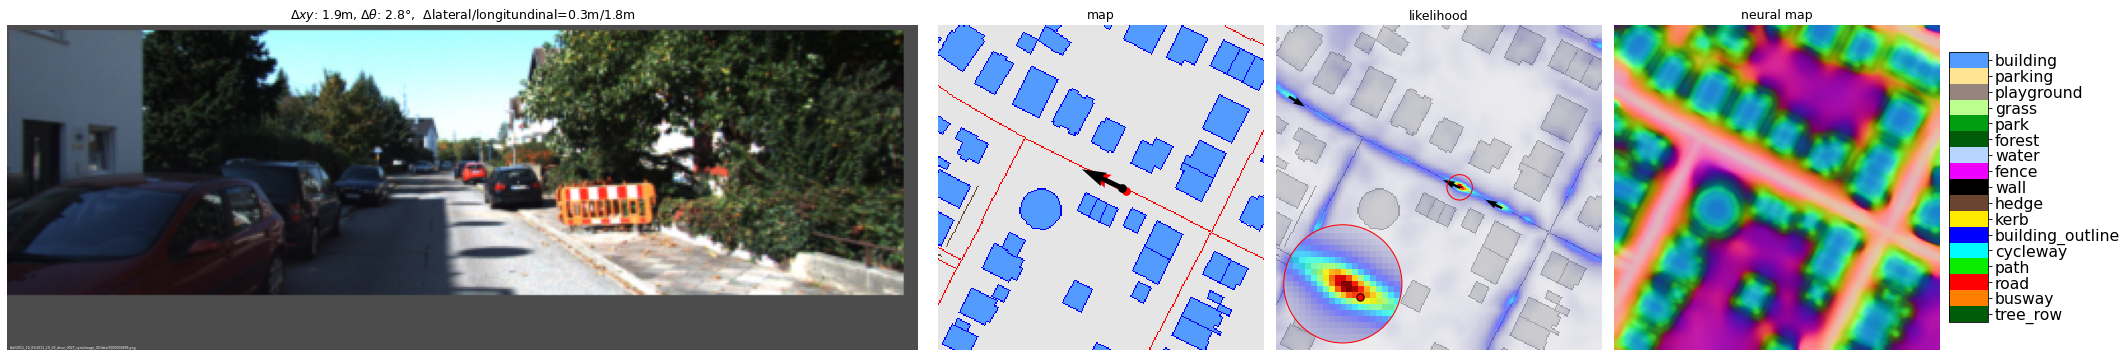

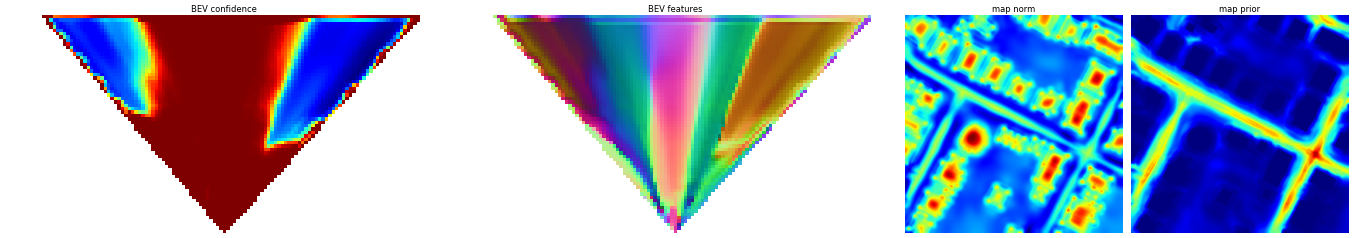

1 5.97 {'xy_max_error': 8.78, 'yaw_max_error': 0.0, 'directional_error': array([0.03, 8.78], dtype=float32)}


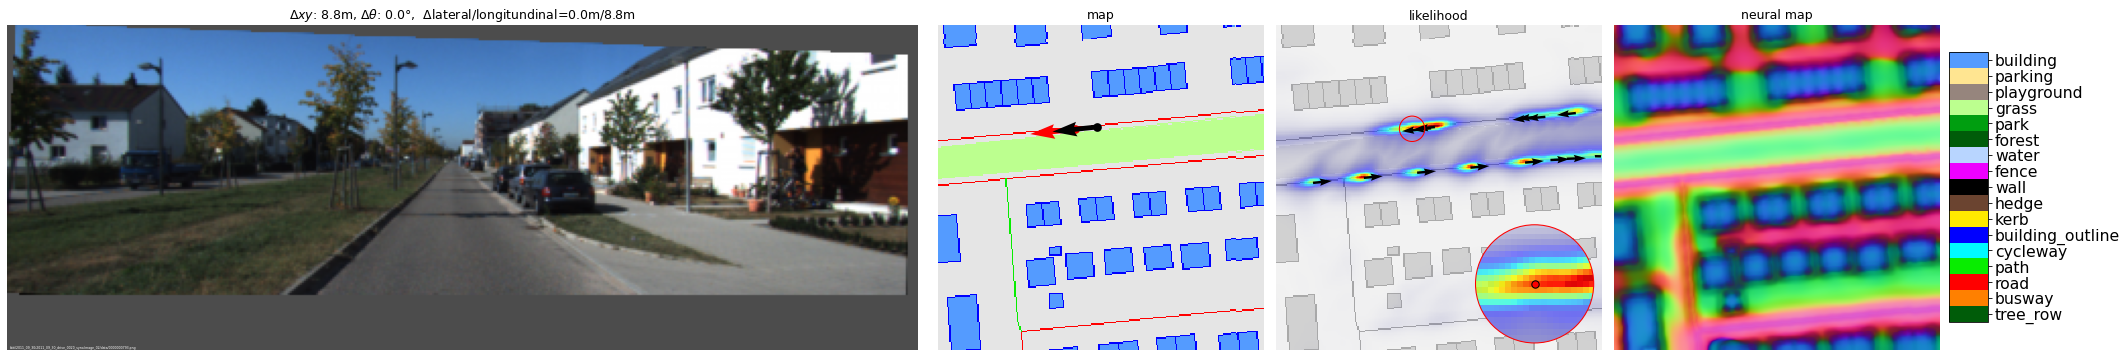

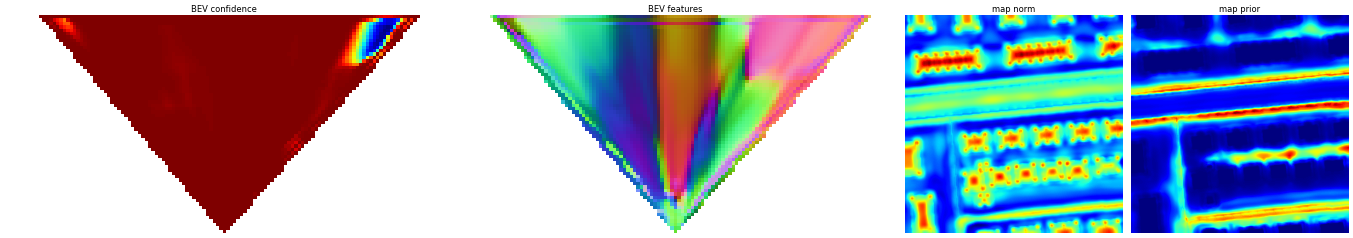

2 inf {'xy_max_error': 4.65, 'yaw_max_error': 2.6, 'directional_error': array([1.35, 4.45], dtype=float32)}


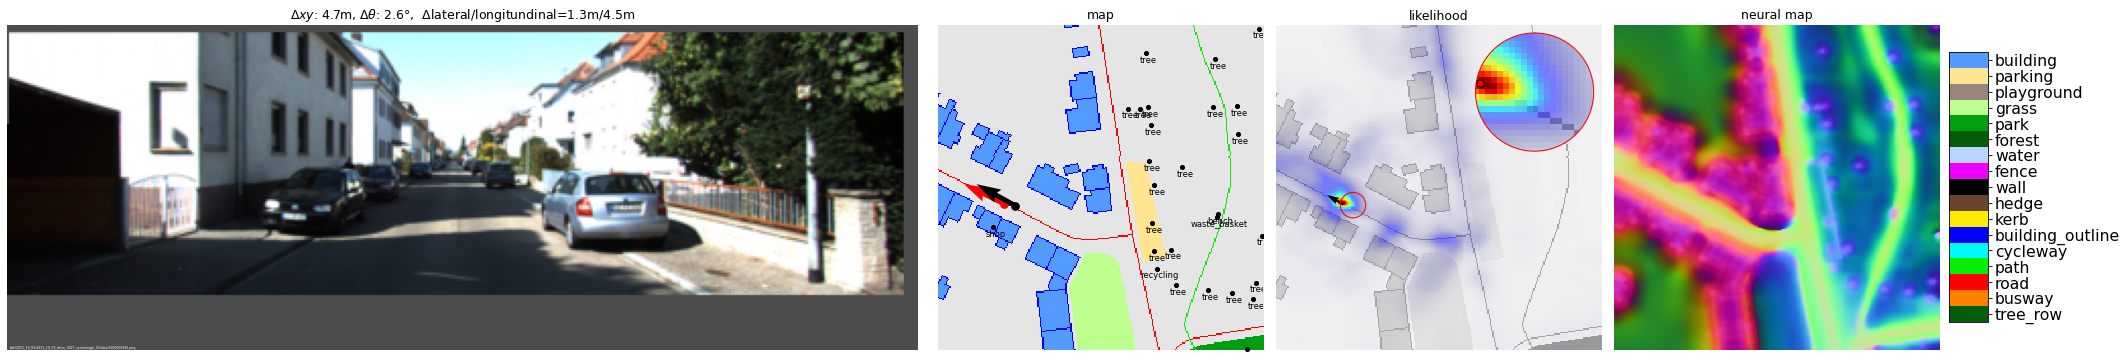

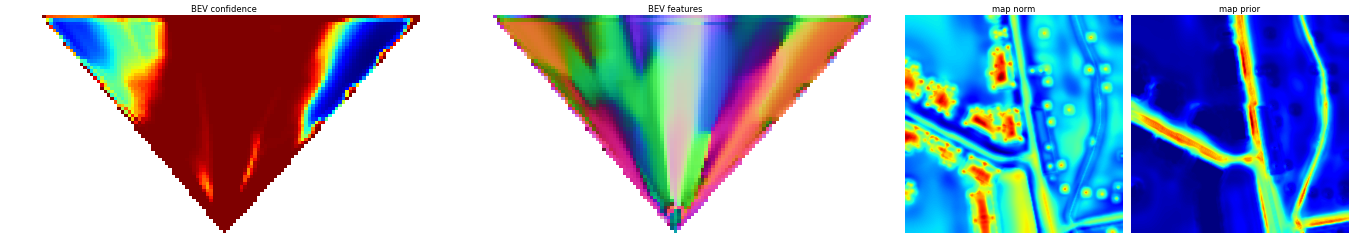

3 10.98 {'xy_max_error': 26.02, 'yaw_max_error': 0.42, 'directional_error': array([ 0.68, 26.02], dtype=float32)}


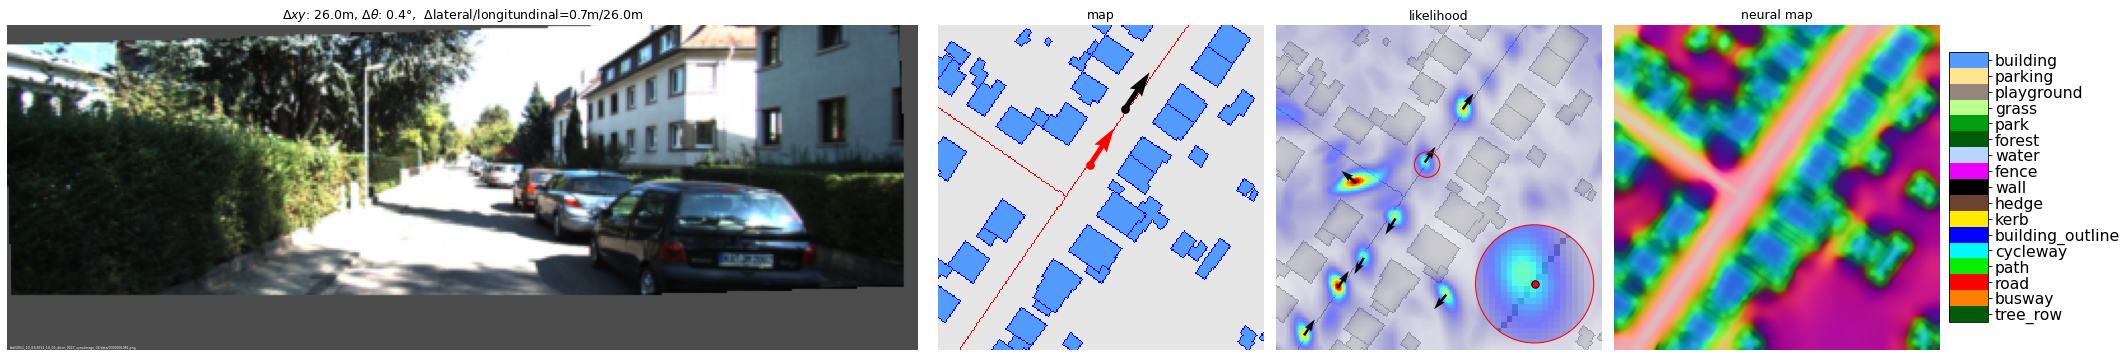

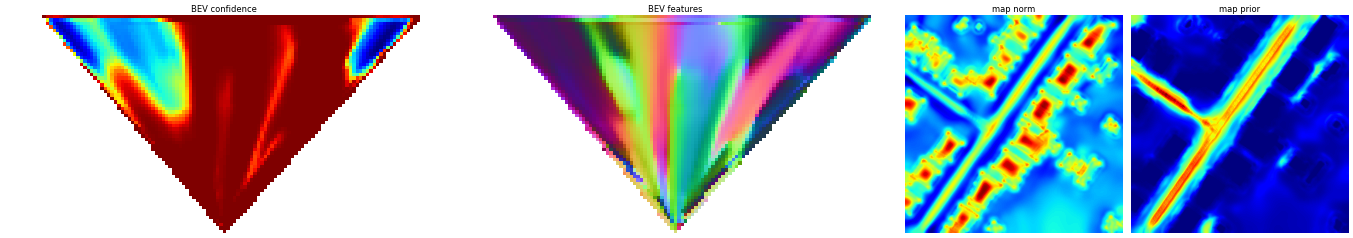

4 14.47 {'xy_max_error': 27.97, 'yaw_max_error': 1.43, 'directional_error': array([21.85, 17.46], dtype=float32)}


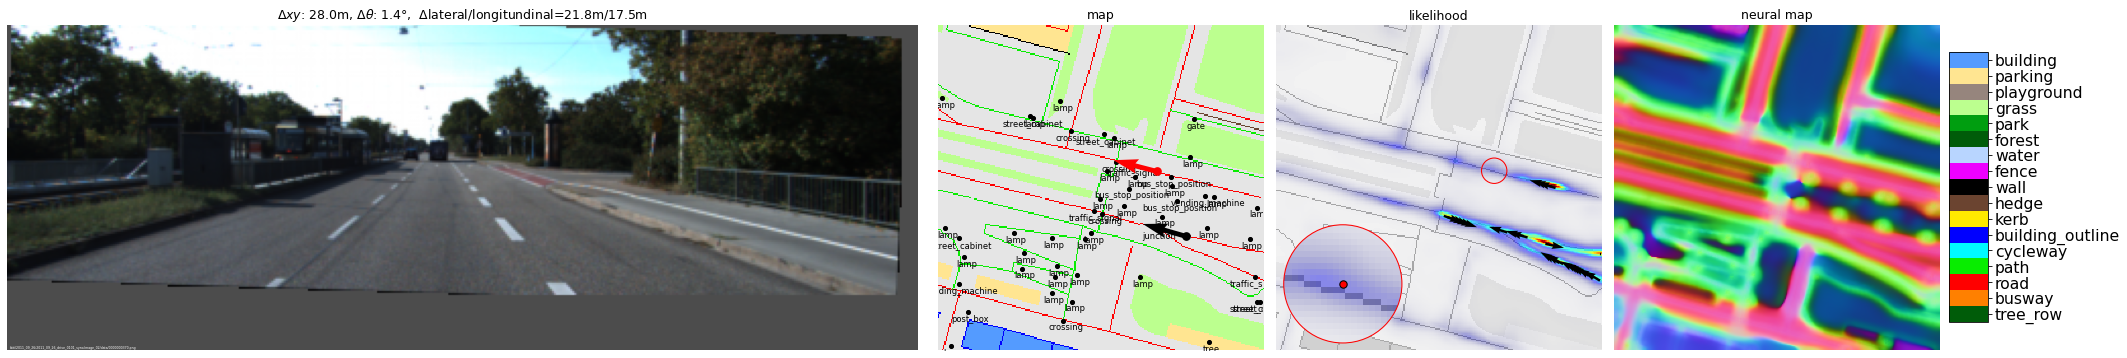

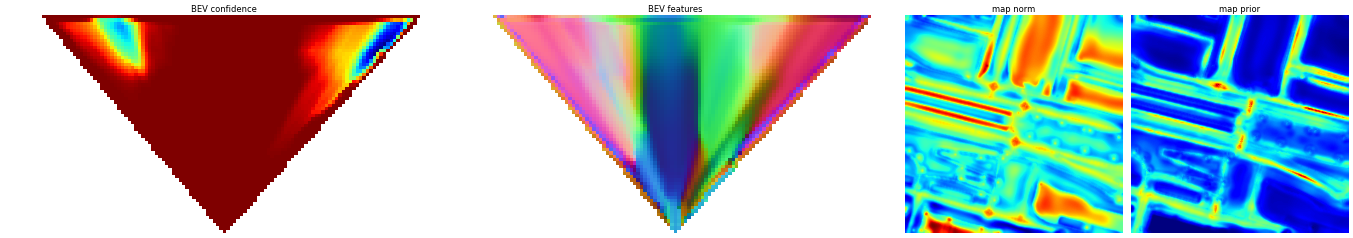

In [45]:
out_dir = "/hkfs/work/workspace/scratch/tj3409-rdaionet/OrienterNet/viz_kitti/rainy"
if out_dir is not None:
    !mkdir -p $out_dir/full
    
seed_everything(25) # best = 25
loader = dataset.dataloader("test", shuffle=sampler is None, sampler=sampler)
metrics = MetricCollection(model.model.metrics()).to(model.device)
metrics["directional_error"] = LateralLongitudinalError(model.cfg.data.pixel_per_meter)
for i, batch in zip(range(5), loader):
    lp_uvt = lp_uv = loss = results = pred = data = batch_ = None
    
    batch_ = model.transfer_batch_to_device(batch, model.device, i)
    pred = model(batch_)
    loss = model.model.loss(pred, batch_)
    results = metrics(pred, batch_)
    results.pop("xy_expectation_error")
    for k in list(results):
        if "recall" in k:
            results.pop(k)
    print(f'{i} {loss["total"].item():.2f}', {k: np.round(v.cpu().numpy(), 2) for k, v in results.items()})
#     if results["xy_max_error"] < 5:
#         continue

    pred = unbatch_to_device(pred)
    data = unbatch_to_device(batch)
    plot_example_single(i, model, pred, data, results, plot_bev=True, out_dir=out_dir, show_dir_error=True)